In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
from statsmodels.tsa.api import SARIMAX, adfuller


In [67]:
def adf_test(series: pd.Series, name: str = ""):
    result = adfuller(series.dropna(), autolag="AIC")

    output = {
        "test_statistic": result[0],
        "p_value": result[1],
        "n_lags": result[2],
        "n_obs": result[3],
        "critical_values": result[4],
    }

    print(f"\nADF Test: {name}")
    print(f"Test Statistic: {output['test_statistic']:.3f}")
    print(f"P-value: {output['p_value']:.4f}")
    print("Critical Values:")
    for k, v in output["critical_values"].items():
        print(f"  {k}: {v:.3f}")

    return output


In [68]:
def make_monthly(y: pd.Series)->pd.Series:
    y = y.copy()
    y.index = pd.to_datetime(y.index)
    y = y.sort_index(ascending=True)

    if y.isna().any():
        y = y.interpolate(limit_direction="both")
    return y

def wape(y_true: np.array, y_pred: np.array)-> float:
    abs_error = np.sum(np.abs(y_true - y_pred))
    sum_actual = np.sum(np.abs(y_true))
    if sum_actual == 0:
        return 0.0
    return abs_error/sum_actual

def mae(y_true: np.array, y_pred: np.array)-> float:
    return np.mean(np.abs(y_true - y_pred))

#repeat last 12 months forward
def naive_forecast(y: pd.Series, horizon: int=6, season_len = 12) -> pd.Series:
    y= make_monthly(y)
    last = y.iloc[-season_len:]
    reps = int(np.ceil(horizon/season_len))
    forecast = pd.concat([last]*reps).iloc[:horizon]

    future_idx = pd.date_range(y.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq="MS")
    forecast.index = future_idx
    return forecast

def fit_sarima(y: pd.Series, order = (1,1,1), seasonal_order=(1,1,1,12)):
    y= make_monthly(y)
    model = SARIMAX(y, order = order, seasonal_order=seasonal_order, trend="n",
                     enforce_stationarity=False, enforce_invertibility= False)
    res = model.fit(disp=False)
    return res

def sarima_forecast(res, horizon: int=6) -> pd.DataFrame:
    prediction = res.get_forecast(steps=horizon)
    mean = prediction.predicted_mean
    ci = prediction.conf_int(alpha=0.05)

    out = pd.DataFrame({
        "p05":ci.iloc[:,0],
        "p50":mean,
        "p95":ci.iloc[:,1]
    })
    return out

def bootstrap(y: pd.Series, horizon: int=6, n: int=1000, seed: int=43,
              order=(1,1,1), seasonal_order=(1,1,1,12)) ->pd.DataFrame:
    y = make_monthly(y).astype(float)
    eps = 1.0
    y_log = np.log(y+eps)
    rng = np.random.default_rng(seed)

    model = fit_sarima(y_log, order=order, seasonal_order=seasonal_order)
    pred = model.get_forecast(steps=horizon)
    mu = pred.predicted_mean.values
    sigma = pred.se_mean.values

    sims_log = mu[:, None] + rng.normal(0.0, sigma[:, None], size=(horizon,n))
    sims = np.exp(sims_log)-eps
    sims = np.clip(sims,0, None)
    
    future_idx = pd.date_range(
        y.index[-1]+pd.offsets.MonthBegin(1),
        periods = horizon,
        freq="MS"
    )
    
    return pd.DataFrame(sims,index=future_idx)

In [69]:
# den_y = pd.read_csv(Path("../data/processed/passenger_volume/den_nov22-oct25.csv"), header=None, index_col=[0])
den_y = (pd.read_csv(Path("../data/processed/passenger_volume/den_nov22-oct25.csv"),
        header=None, names=["month", "passengers"], parse_dates=["month"], index_col="month")["passengers"].sort_index().asfreq("MS"))
print(adf_test(den_y, "Denver Passenger Volume"))
print(adf_test(den_y.diff(), "Denver Passenger Volumes diff"))



ADF Test: Denver Passenger Volume
Test Statistic: -3.159
P-value: 0.0225
Critical Values:
  1%: -3.633
  5%: -2.949
  10%: -2.613
{'test_statistic': np.float64(-3.158999745247827), 'p_value': np.float64(0.022484015090245005), 'n_lags': 0, 'n_obs': 35, 'critical_values': {'1%': np.float64(-3.6327426647230316), '5%': np.float64(-2.9485102040816327), '10%': np.float64(-2.6130173469387756)}}

ADF Test: Denver Passenger Volumes diff
Test Statistic: -8.872
P-value: 0.0000
Critical Values:
  1%: -3.738
  5%: -2.992
  10%: -2.636
{'test_statistic': np.float64(-8.872483690167131), 'p_value': np.float64(1.3859313787467175e-14), 'n_lags': 10, 'n_obs': 24, 'critical_values': {'1%': np.float64(-3.7377092158564813), '5%': np.float64(-2.9922162731481485), '10%': np.float64(-2.635746736111111)}}


In [70]:
#naive_forecast
den_naive = naive_forecast(den_y, horizon=6)
##backtesting
train = den_y.iloc[:-6]
test = den_y.iloc[-6:]

res = fit_sarima(train)
sarima_fc = res.get_forecast(steps=6).predicted_mean

#metrics
fc_mae = mae(test, sarima_fc)
fc_wape = wape(test, sarima_fc)
print("sarima_mae:",fc_mae)
print("sarima wape", fc_wape)

naive_comparison = naive_forecast(train, horizon=6)
naive_mae = mae(test,naive_comparison)
naive_wape = wape(test, naive_comparison)
print("naive mae:", naive_mae)
print("naive wape:", naive_wape)

#final model
final_res = fit_sarima(den_y)
final_forecast = sarima_forecast(final_res, horizon=6)

residuals = final_res.resid.dropna()
print(residuals.mean(),residuals.std())


sarima_mae: 18799.325625734444
sarima wape 0.04395760189991207
naive mae: 27756.166666666668
naive wape: 0.06490097298653906


c:\Users\ivanl\miniconda3\envs\airport_demand_forecasting\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ivanl\miniconda3\envs\airport_demand_forecasting\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


-43951.8206153977 129322.94214822698


In [71]:
#monte carlo simulations
x=2500
sims = bootstrap(den_y, horizon=6, n=x)
# print(sims.info())
thousand_den_y = pd.concat([den_y]*x, axis=1)
# print(thousand_den_y.head(2))
sims.columns = thousand_den_y.columns
monte_carlo_result = pd.concat([thousand_den_y,sims], axis=0)




c:\Users\ivanl\miniconda3\envs\airport_demand_forecasting\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [72]:
print("resid mean", residuals.mean())
print("resid std", residuals.std(ddof=1))
print("resid quantiles", np.quantile(residuals, [0.01, 0.05, 0.5, 0.95, 0.99]))

resid mean -43951.8206153977
resid std 129322.94214822698
resid quantiles [-274141.48098779 -259540.72543075    -790.49783547  110335.05242153
  208218.14891006]


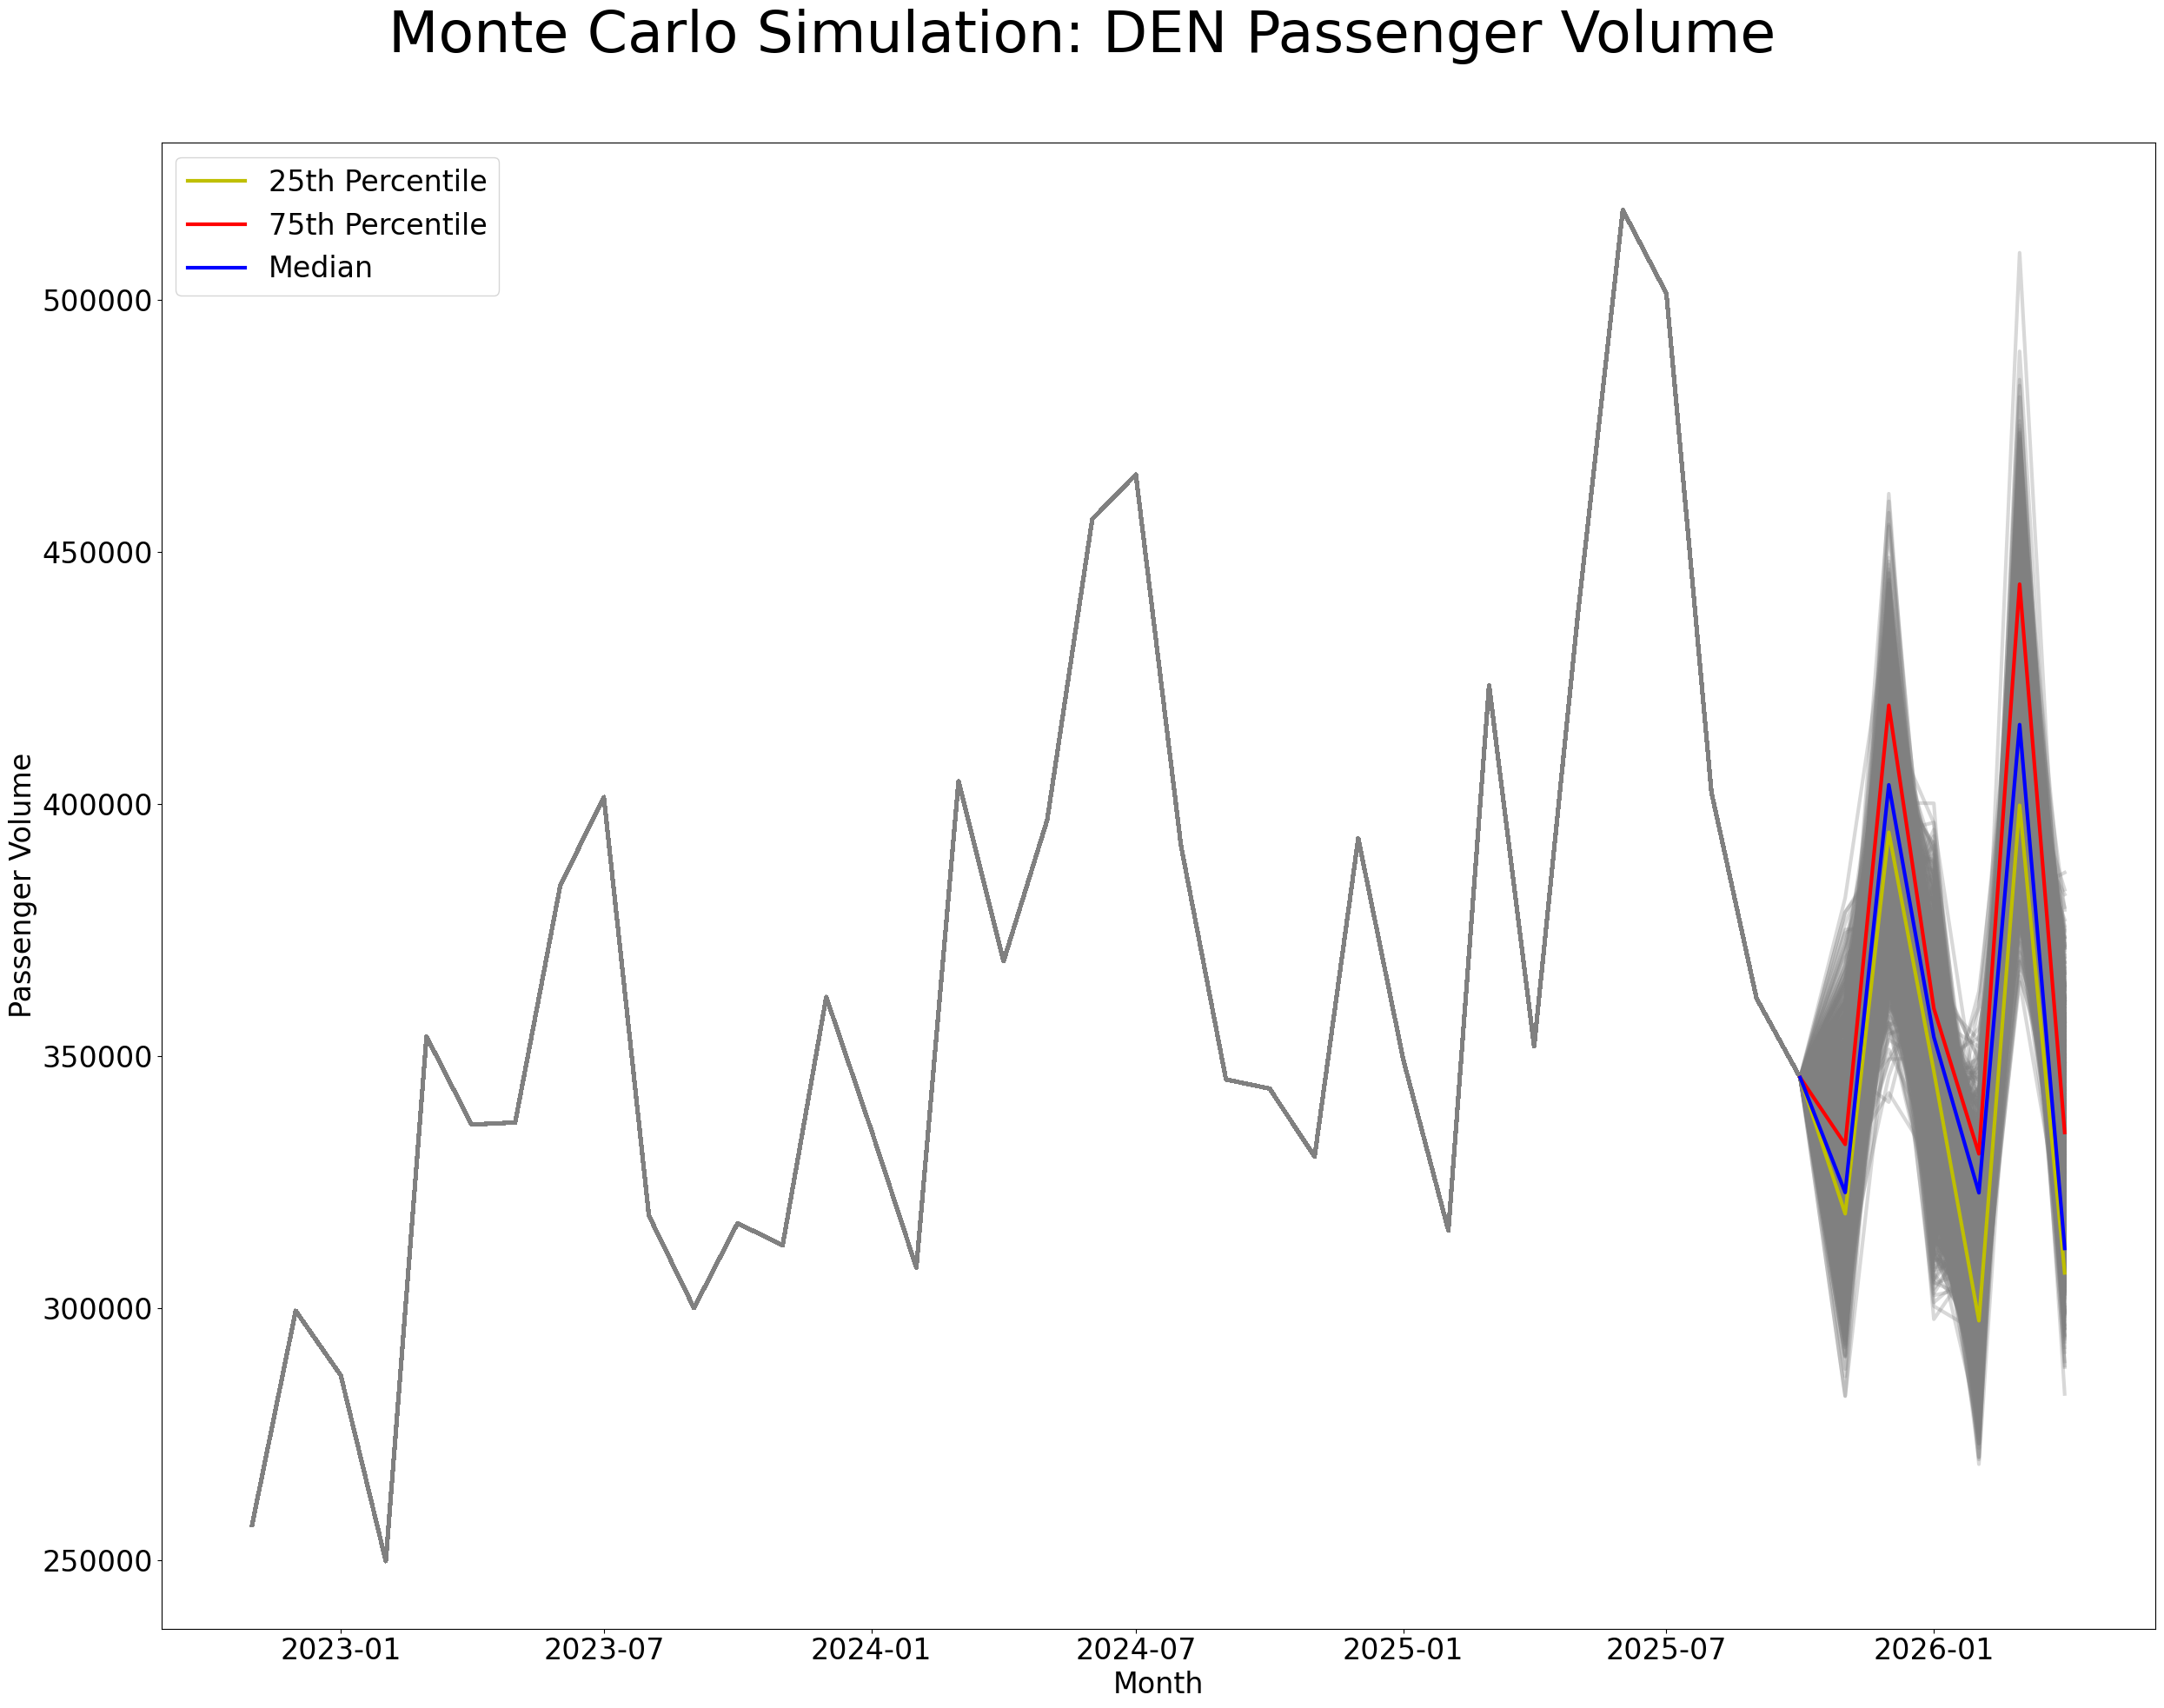

In [85]:
mc_q25 = monte_carlo_result.iloc[:,-6:].quantile(0.25,axis=1)
mc_med = monte_carlo_result.iloc[:,-6:].quantile(0.50,axis=1)
mc_q75 = monte_carlo_result.iloc[:,-6:].quantile(0.75,axis=1)

fig = plt.figure(figsize=(25,20))
fig.suptitle("Monte Carlo Simulation: DEN Passenger Volume",fontsize=48)
plt.plot(monte_carlo_result, color='grey', alpha=0.3,linewidth=3.0)
plt.plot(mc_q25.iloc[-7:],color = 'y',linewidth=3.0, label='25th Percentile')
plt.plot(mc_q75.iloc[-7:],color='r',linewidth=3.0, label='75th Percentile')
plt.plot(mc_med.iloc[-7:], color='b',linewidth=3.0, label='Median')
plt.xlabel('Month',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Passenger Volume',fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

def mc_sim_plot(airport: str, mc: pd.DataFrame, filepath: Path, horizon: int=6) -> None:
    q25 = mc.iloc[:,-(horizon):].quantile(0.25,axis=1)
    med = mc.iloc[:,-(horizon):].quantile(0.50,axis=1)
    q75 = mc.iloc[:,-(horizon):].quantile(0.75,axis=1)

    fig = plt.figure(figsize=(30,20))
    fig.suptitle(f"Monte Carlo Simulation: {airport} Passenger Volume",fontsize=48)
    fig.plot(mc, color='grey', alpha=0.3,linewidth=3.0)
    fig.plot(q25.iloc[-(horizon+1):],color = 'y',linewidth=3.0, label='25th Percentile')
    fig.plot(q75.iloc[-(horizon+1):],color='r',linewidth=3.0, label='75th Percentile')
    fig.plot(med.iloc[-(horizon+1):], color='b',linewidth=3.0, label='Median')
    fig.xlabel('Month',fontsize=24)
    fig.xticks(fontsize=24)
    fig.ylabel('Passenger Volume',fontsize=24)
    fig.yticks(fontsize=24)
    fig.legend(loc='upper left', fontsize=24)
    fig.savefig(filepath / f"{airport}_monte_carlo_sim.svg",dpi=150)
    fig.savefig(filepath / f"{airport}_monte_carlo_sim.jpg",dpi=150)
    plt.close(fig)

